In [1]:
import artm

In [2]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [3]:
import numpy as np
import pandas as pd

In [4]:
batch_vectorizer = artm.BatchVectorizer(data_path="lectures.txt", data_format="vowpal_wabbit", target_folder="batch_folder", 
                                       batch_size=7)

##### Инициализация модели

In [5]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
myartm = artm.ARTM(num_topics=T, topic_names=topic_names, class_ids={"text":1, "author":1}, 
                       num_document_passes=1, reuse_theta=True, cache_theta=True, seed=1)

In [6]:
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)
myartm.initialize(dictionary=dictionary)

##### Добавление score

In [7]:
myartm.scores.add(artm.TopTokensScore(name='top_words', num_tokens=15, class_id='text'))
myartm.scores.add(artm.TopTokensScore(name='top_authors', num_tokens=15, class_id='author'))
myartm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                           use_unigram_document_model=False,
                                           dictionary=dictionary))

##### Построение модели

In [8]:
myartm.regularizers.add(artm.SmoothSparsePhiRegularizer(tau=1e5, dictionary='dictionary', 
                                                            class_ids=['text'], topic_names=['bcg']))

In [9]:
myartm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

In [10]:
myartm.regularizers.add(artm.SmoothSparsePhiRegularizer(tau=-1e5, dictionary='dictionary', 
                                                            class_ids=['text'], topic_names=topic_names[:-1]))

In [11]:
myartm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

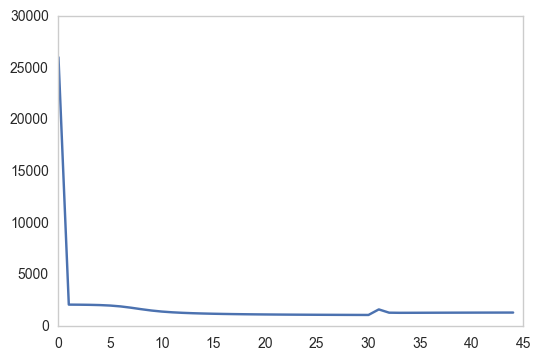

In [12]:
plt.plot(myartm.score_tracker["PerplexityScore"].value)

##### Интерпретация тем

In [58]:
for topic_name in myartm.topic_names:
    print topic_name + ': '
    print 'Authors:'
    authors = myartm.score_tracker['top_authors'].last_tokens
    for author in authors[topic_name]:
        print author,
    print '\nKeywords:'
    words = myartm.score_tracker['top_words'].last_tokens
    for word in words[topic_name]:    
        print word,
    print '\n'
    

sbj0: 
Authors:
Дмитрий_Казаков Михаил_Данилов Сергей_Майоров Виктор_Брагута Павел_Пахлов Игорь_Волобуев Валерий_Рубаков Сергей_Троицкий Лев_Дудко Лев_Беклемишев Анатолий_Лиходед Эдуард_Боос Дэвид_Гросс Сергей_Гашков Жан-Арыс_Джилкибаев 
Keywords:
частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый 

sbj1: 
Authors:
Артем_Оганов Валерий_Фокин Дмитрий_Паращук Валентин_Ненайденко Владимир_Пудалов Валентин_Крапошин Евгений_Гудилин Дмитрий_Гольберг Иван_Сорокин Наталья_Берлофф Дмитрий_Клинов Сергей_Морозов Евгений_Антипов Вадим_Бражкин Владимир_Комлев 
Keywords:
материал температура структура вещество химический соединение свойство поверхность химия давление углерод сверхпроводимость металл применение полимер 

sbj2: 
Authors:
Алексей_Юдин Михаил_Бойцов Дина_Гусейнова Иван_Ладынин Андрей_Лукашов Татьяна_Смоктунович Зоригто_Намсараев Владимир_Малахов Кирилл_Мартынов Руслан_Хестанов Ольга_Тогоева Фёдор_Успенский Ю

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [13]:
sbj_topic_labels = [u'Физика', u'Материаллы', u'Государство', u'Образование', u'Развитие', u'Мифы', u'Русский', u'Расы', u'Право',
                    u'Медицина', u'Микроорганизмы', u'Память', u'Германия', u'Наука', u'Астрономия', u'Экономика',
                    u'Психология', u'Алгоритмы', u'Востоковедение', u'Генетика', u'Фотоны', u'Философия',u'Политика',
                    u'СССР', u'Религия', u'Теор-физика', u'Искусство', u'Вселенная', u'Кино']

topic_labels = sbj_topic_labels + [u'Фоновая тема']

##### Анализ тем

In [17]:
myartm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 

theta = myartm.get_theta()
phi_a = myartm.get_phi(class_ids=['author'])
print("theta : {}".format(theta.shape))
print("phi : {}".format(phi_a.shape))

theta : (30, 1728)
phi : (539, 30)


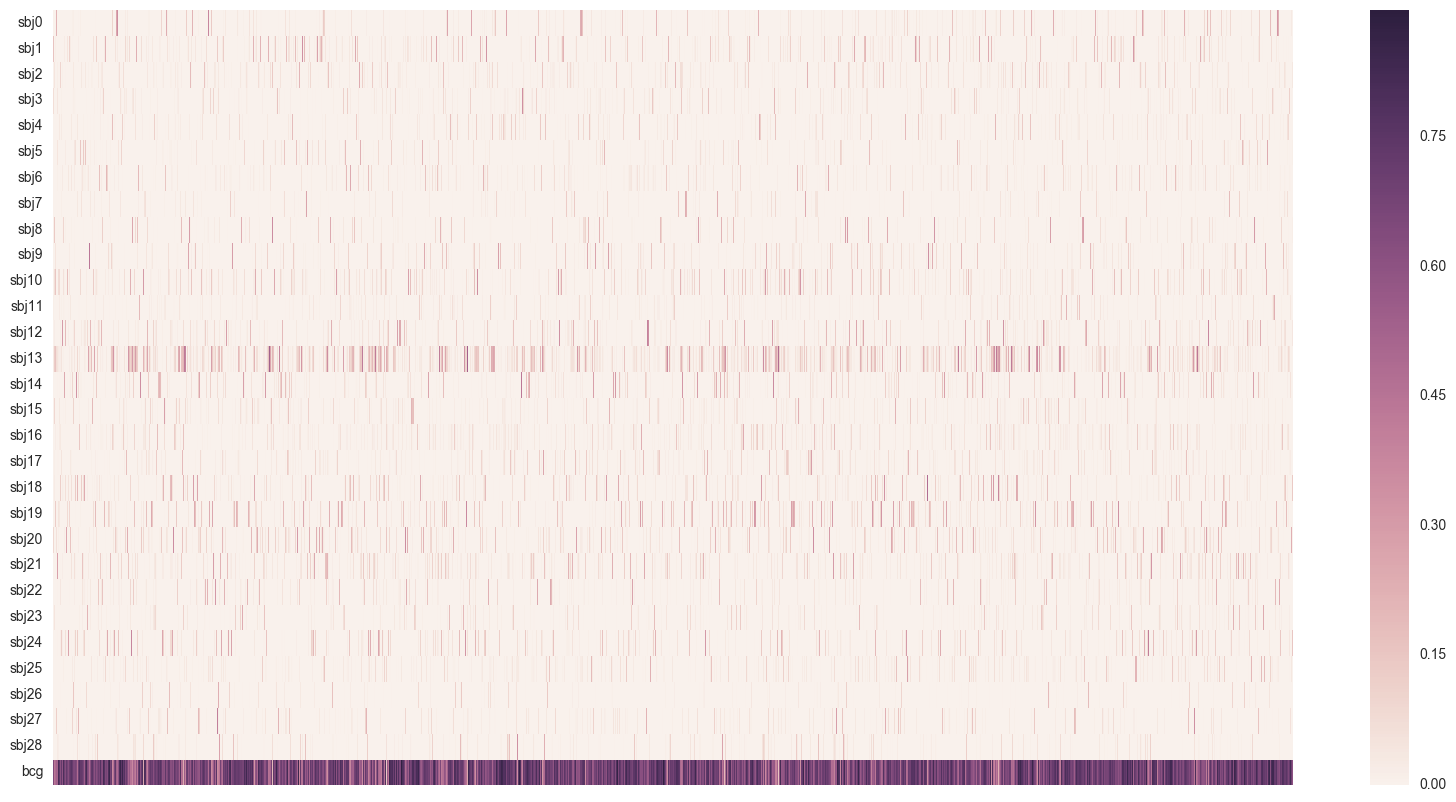

In [18]:
fig = plt.figure(figsize=(20, 10))
seaborn.heatmap(theta[:100], xticklabels=False)

In [34]:
Pt = pd.DataFrame(theta.sum(axis=1) / theta.shape[1])

In [35]:
sorted_Pt = Pt.sort_values(by=[0], ascending=True)
sorted_Pt.head(30)

,0
sbj26,0.003070
sbj7,0.004716
sbj11,0.005467
sbj23,0.006300
sbj5,0.006362
sbj3,0.006383
sbj28,0.006562
sbj4,0.006586
sbj6,0.007619
sbj27,0.007977


In [38]:
mxi = sorted_Pt[-6:-1] # кроме Фоновой темы (самой популярной)
mni = sorted_Pt[:3]

indexes1 = [w.replace('sbj', '') for w in mxi.index[::-1]] # reverse order
indexes2 = [w.replace('sbj', '') for w in mni.index] # no need to reverse order

print '5 тем  с max p(t), по убыванию: ', 
for i in indexes1: print topic_labels[int(i)] + '(sbj'+i+')  ',
print
print '3 темы с min p(t), по возрастанию: ', 
for i in indexes2 : print topic_labels[int(i)] + '(sbj'+i+')  ', 

5 тем  с max p(t), по убыванию:  Наука(sbj13)   Генетика(sbj19)   Фотоны(sbj20)   Религия(sbj24)   Микроорганизмы(sbj10)  
3 темы с min p(t), по возрастанию:  Искусство(sbj26)   Расы(sbj7)   Память(sbj11)  


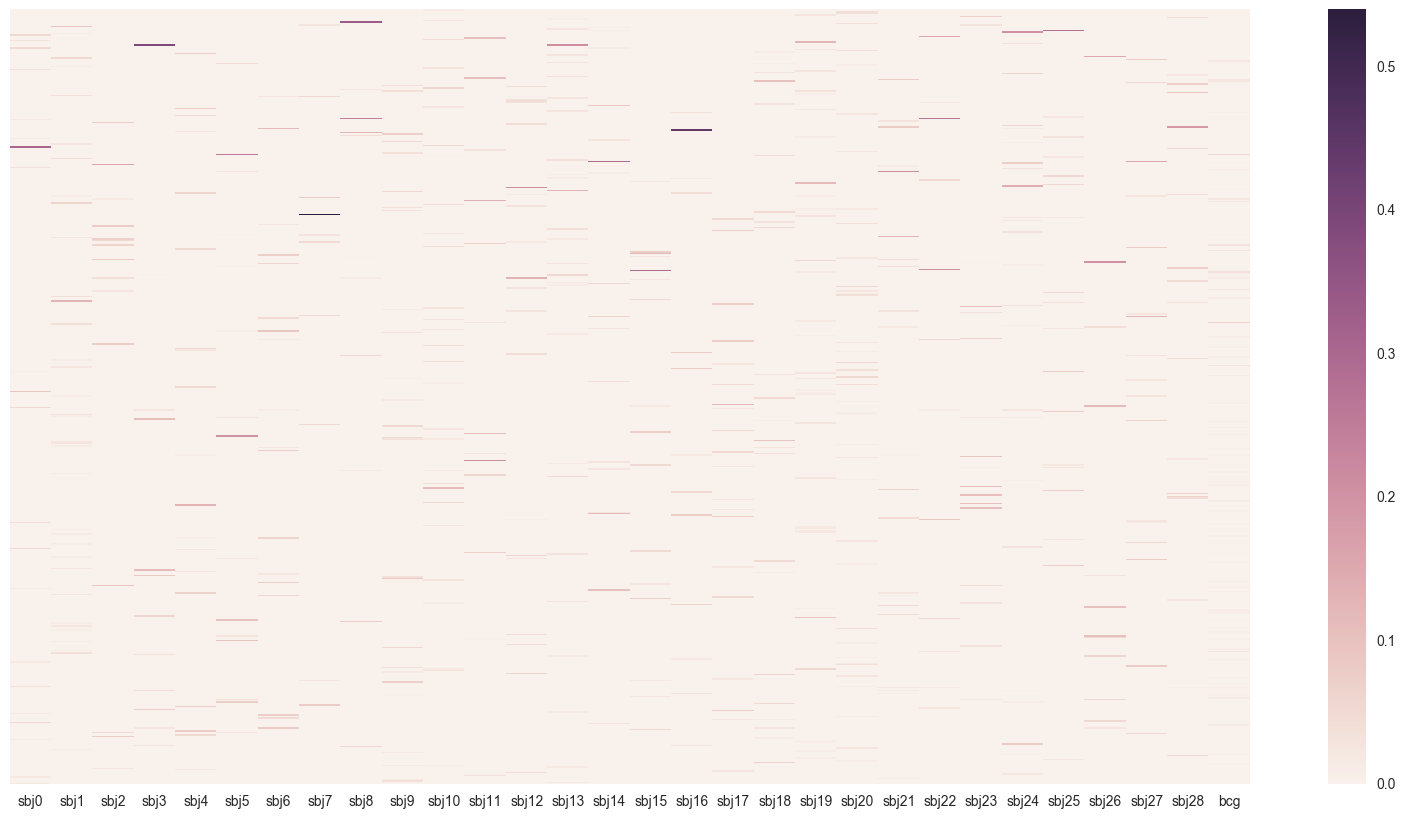

In [19]:
fig = plt.figure(figsize=(20, 10))
seaborn.heatmap(phi_a, yticklabels=False)

In [20]:
authors_themes = np.sum(phi_a > 0.01, axis=1)
short_list = authors_themes[authors_themes >= 3]
print short_list.index

Index([u'Фёдор_Успенский', u'Илья_Иткин', u'Олег_Ауров', u'Ольга_Вайнштейн',
       u'Андрей_Журавлев', u'Александр_Пиперски'],
      dtype='object')


##### Построение тематической карты авторов

In [41]:
import sklearn
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [42]:
temp = phi_a.values * Pt.values.T
Pta = temp/np.sum(temp)
N_authors, _ = Pta.shape

In [43]:
distances = pairwise_distances(Pta, metric='cosine')
mds = MDS(dissimilarity='precomputed')
mds_transf = mds.fit_transform(distances)

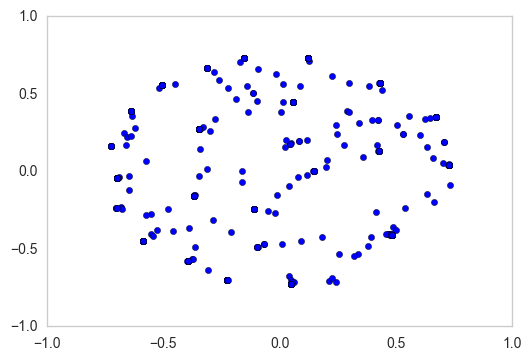

In [44]:
plt.scatter(mds_transf[:, 0], mds_transf[:, 1])

In [84]:
author_theme_color = Pta.argmax(axis=1)
ii = (author_theme_color==3)
short_phi = phi_a[ii]
# names = short_phi.index.tolist() # list of authors names
names_weight = np.sum(short_phi, axis=1)
print names_weight

print np.max(names_weight)

x = list(mds_transf[ii,0])
y = list(mds_transf[ii,1])
for i, n in enumerate(names):
    print n, x[i], y[i]

Татьяна_Клячко           0.108479
Наталья_Ростиславлева    0.113102
Григорий_Крейдлин        0.121936
Алексей_Котов            0.037701
Максим_Демин             0.075402
dtype: float32
0.121936
Татьяна_Клячко 0.537661259743 -0.237764539601
Наталья_Ростиславлева 0.213682063472 -0.708007961156
Григорий_Крейдлин 0.0885390441964 0.551268046069
Алексей_Котов 0.24274237394 0.300921947501
Максим_Демин 0.0133792555035 0.564690384396


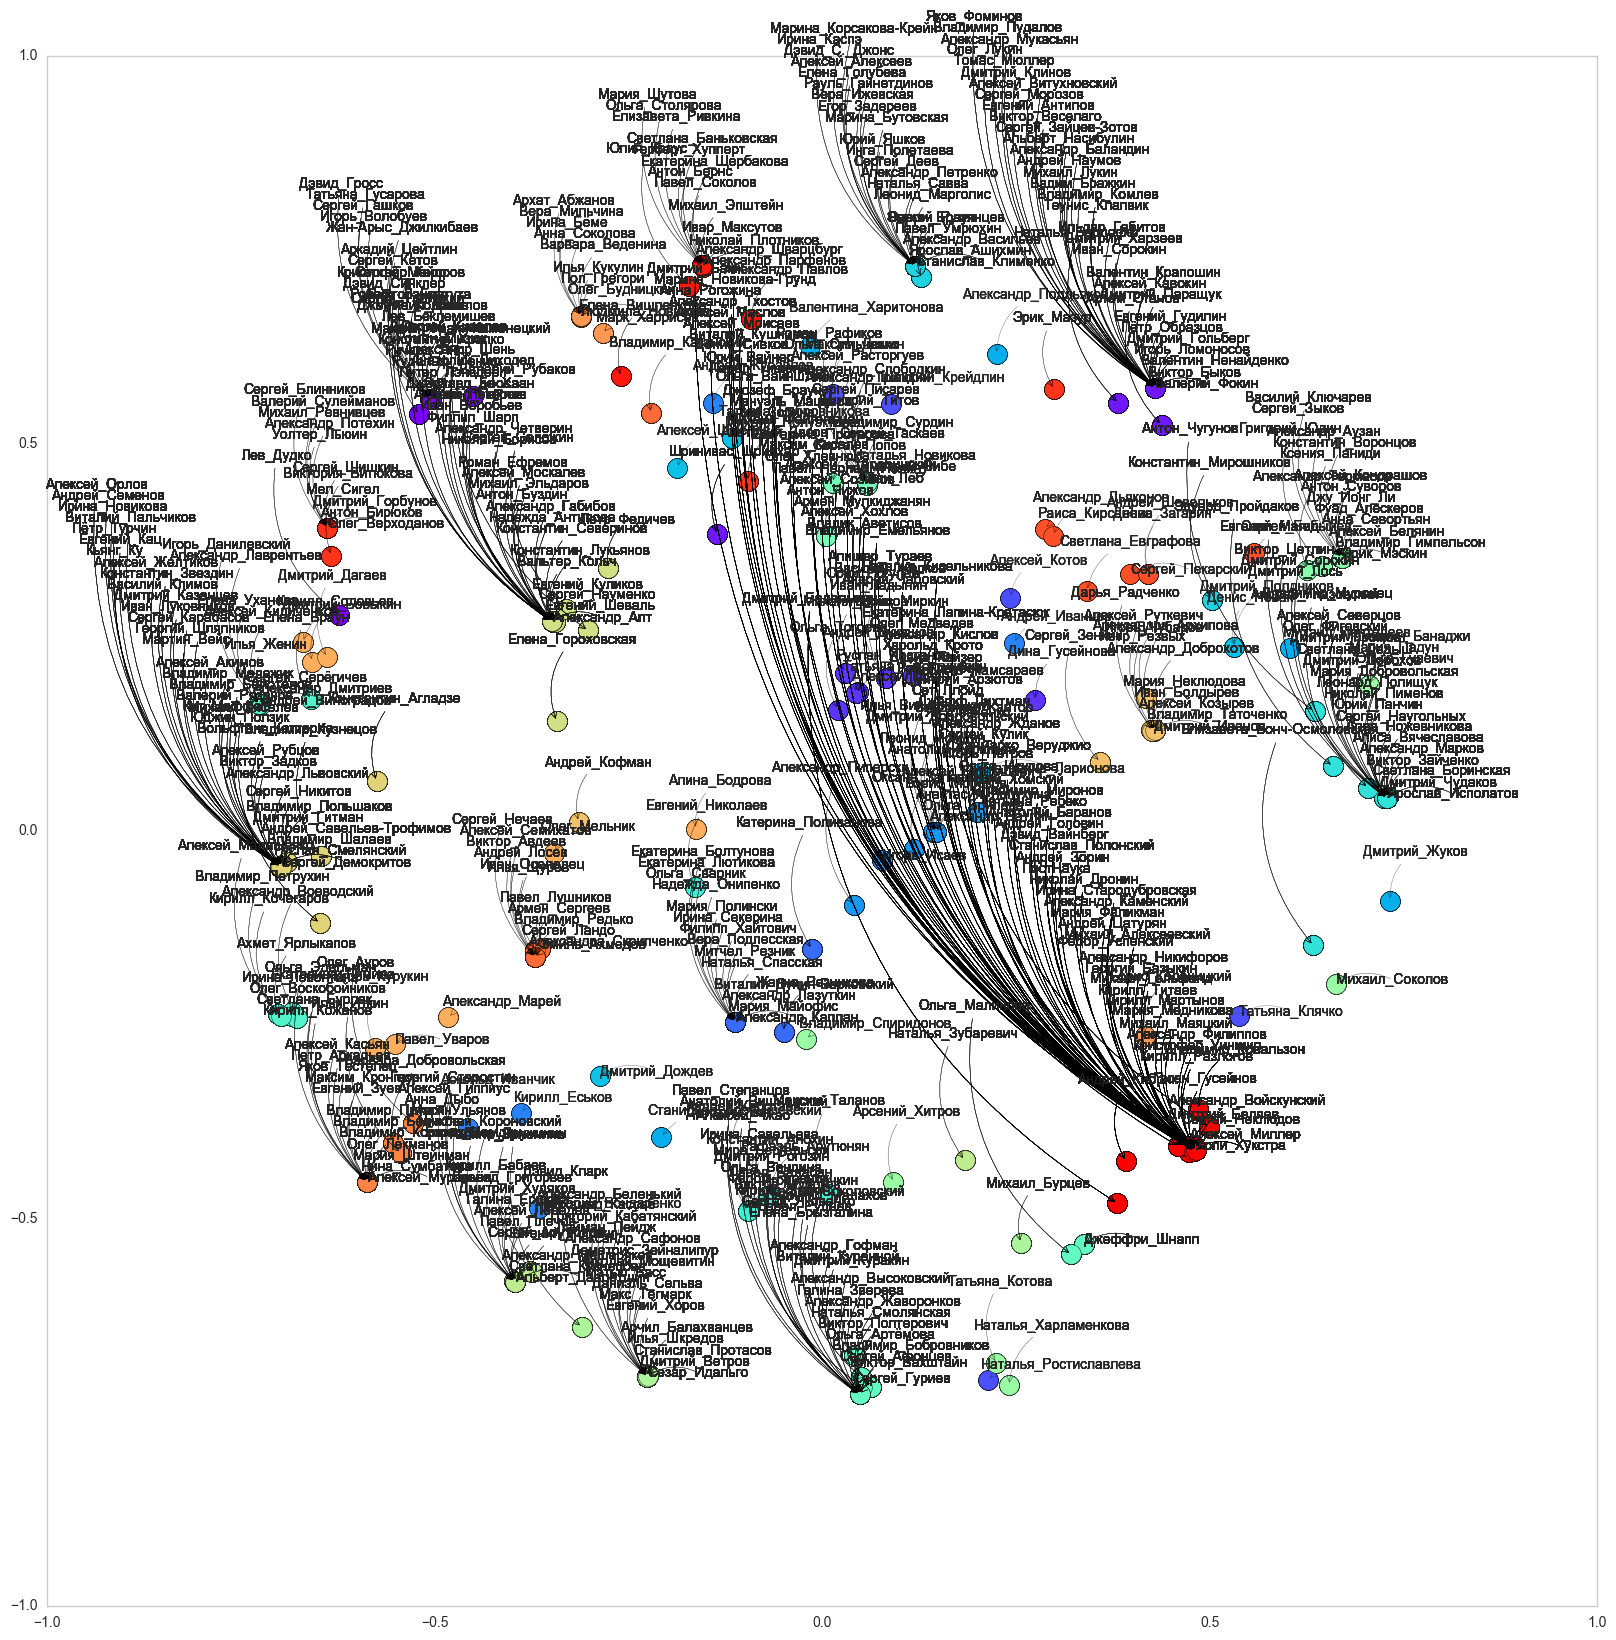

In [88]:
import matplotlib.cm as cm
theme_colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код
fig = plt.figure(figsize=(20, 20))
author_theme_color = Pta.argmax(axis=1)

def show_annotation(name, x, y, offset):
    plt.annotate(name, (x, y), 
                         textcoords = 'offset points', 
                         xytext = (-5*offset, 8*offset),
                         arrowprops = dict(arrowstyle='->', connectionstyle='arc3, rad=0.3', alpha=0.1), 
                         )

for c in author_theme_color:
    ii = (author_theme_color==c)  # authors with the same favorite theme
    x = list(mds_transf[ii,0])
    y = list(mds_transf[ii,1])
    short_phi = phi_a[ii]
    names = short_phi.index.tolist() # list of authors names
    names_amount = len(names)
        
    plt.scatter(x, y, c=theme_colors[c], s=200)
    
    for i in xrange(names_amount):
        show_annotation(names[i], x[i], y[i], i)
  
plt.savefig('sokol_authors.pdf')

##### Создание простого тематического навигатора по Постнауке

In [91]:
# Ваш код
Pdt = theta.div(theta.sum(axis=1), axis=0)

theme_top_topics = np.ones((T, 10)).astype(int)
for  i in  xrange(T):
    lst = Pdt.values[i, :].argsort()[-10:].astype(int) # return sorted indexes of sorted values by ascending (only) 
    theme_top_topics[i] = lst[::-1].astype(int)  # reverse them   

In [92]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

In [96]:
topic_index = 0
for topic_name in myartm.topic_names:
    
    display(HTML('<h1>' + u'Тема:  ' + topic_labels[topic_index] + '</h1>'))  # topic name
    
    words = myartm.score_tracker['top_words'].last_tokens    # top words in green
    all_words = " ".join(words[topic_name])
    display(HTML('<h2>' + '<font color="green">' + u'Ключевыe слова:' + '</font>'+ '</h2>'))
    display(HTML('<font color="green">' + all_words + '</font>'))
   
    display(HTML('<h2>' + '<font color="blue">' + u'10 основных статей:' + '</font>'+ '</h2>'))
    for topic in Pdt.columns[theme_top_topics[topic_index]]:
        display(HTML((u'<a href={}>{}</a>').format(topic, topic)))
 
    topic_index +=1